# Identifying phishing mails by using URL and mail features and ML based classification tools

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Constructing-Dataset" data-toc-modified-id="Constructing-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Constructing Dataset</a></span><ul class="toc-item"><li><span><a href="#Importing-libraries-and-defining-constants" data-toc-modified-id="Importing-libraries-and-defining-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing libraries and defining constants</a></span></li><li><span><a href="#Downloading-and-extracting-mails-(phishing-and-ham-mails)" data-toc-modified-id="Downloading-and-extracting-mails-(phishing-and-ham-mails)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Downloading and extracting mails (phishing and ham mails)</a></span></li><li><span><a href="#Loading-mails" data-toc-modified-id="Loading-mails-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading mails</a></span></li><li><span><a href="#Mail-Features-extraction-functions" data-toc-modified-id="Mail-Features-extraction-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Mail Features extraction functions</a></span><ul class="toc-item"><li><span><a href="#Mail-body-features" data-toc-modified-id="Mail-body-features-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Mail body features</a></span></li><li><span><a href="#URL-features" data-toc-modified-id="URL-features-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>URL features</a></span></li></ul></li><li><span><a href="#Constructing-dataset-by-extracting-various-features" data-toc-modified-id="Constructing-dataset-by-extracting-various-features-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Constructing dataset by extracting various features</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Visualization:-Matplotlib" data-toc-modified-id="Visualization:-Matplotlib-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualization: Matplotlib</a></span></li><li><span><a href="#Histogram,-PDF-and-CDF" data-toc-modified-id="Histogram,-PDF-and-CDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Histogram, PDF and CDF</a></span></li><li><span><a href="#Violin-plots" data-toc-modified-id="Violin-plots-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Violin plots</a></span></li><li><span><a href="#Principal-Component-Analysis" data-toc-modified-id="Principal-Component-Analysis-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Principal Component Analysis</a></span><ul class="toc-item"><li><span><a href="#PCA-for-visualization" data-toc-modified-id="PCA-for-visualization-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>PCA for visualization</a></span></li><li><span><a href="#PCA-for-dimentionality-reduction" data-toc-modified-id="PCA-for-dimentionality-reduction-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>PCA for dimentionality reduction</a></span></li></ul></li><li><span><a href="#t-SNE-using-Scikit-Learn" data-toc-modified-id="t-SNE-using-Scikit-Learn-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>t-SNE using Scikit-Learn</a></span></li></ul></li></ul></div>

## Constructing Dataset

### Importing libraries and defining constants

In [4]:
import os
from bs4 import BeautifulSoup
import mailparser
from collections import OrderedDict
import email
from urllib.request import urlretrieve
import tarfile
import shutil
import numpy as np
import glob
import mailparser
import re
import tldextract
import urllib.request
import warnings
import logging
import csv
import sys

warnings.filterwarnings('ignore')

URLREGEX = r"^(https?|ftp)://[^\s/$.?#].[^\s]*$"
URLREGEX_NOT_ALONE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
FLASH_LINKED_CONTENT = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf"
HREFREGEX = '<a\s*href=[\'|"](.*?)[\'"].*?\s*>'
IPREGEX = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?))\b"
MALICIOUS_IP_URL = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\/(www|http|https|ftp))\b"
EMAILREGEX = r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
GENERAL_SALUTATION = r'\b(dear|hello|Good|Greetings)(?:\W+\w+){0,6}?\W+(user|customer|seller|buyer|account holder)\b'
DATASETS_DIR = 'datasets'
MODELS_DIR = 'models'
TAR_DIR = os.path.join(DATASETS_DIR, 'tar')


PHISHING_URL = '../datasets/tar/phishing_mails.tar.xz'
HAM_URL = '../datasets/tar/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = '../datasets/tar/20021010_hard_ham.tar.bz2'

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.StreamHandler(sys.stdout)

<StreamHandler stdout (NOTSET)>

### Downloading and extracting mails (phishing and ham mails)

In [5]:


def download_dataset(url):
    """download and unzip data from a url into the specified path"""

    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)

    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    print(filename)
    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
    except:
        urlretrieve(url, tarpath)

    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(DATASETS_DIR, tar.getnames()[0])
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=DATASETS_DIR)

        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)

    return dirname

In [6]:
ham_dir = download_dataset(HAM_URL)
hard_ham_dir = download_dataset(HARD_HAM_URL)
phishing_dir = download_dataset(PHISHING_URL)

20030228_easy_ham_2.tar.bz2
20021010_hard_ham.tar.bz2
phishing_mails.tar.xz


### Loading mails

In [7]:

def load_dataset(dirpath):
    """load emails from the specified directory"""

    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files

In [ ]:
# load the datasets
phishing = load_dataset(phishing_dir)
phishing = phishing[:1650]
print("Number of phishing mails: ",len(phishing))
ham = load_dataset(ham_dir)
ham = ham + load_dataset(hard_ham_dir)
print("Number of ham mails: ",len(ham))

### Mail Features extraction functions

#### Mail body features

In [9]:

def getMailBody(mail):
    try:
        mail_body = mailparser.parse_from_string(mail).body.lower()
    except UnicodeDecodeError as Argument:
        parsed_mail = email.message_from_string(mail)
        body = ""
        if parsed_mail.is_multipart():
            for part in parsed_mail.walk():
                # returns a bytes object
                payload = part.get_payload(decode=True)
                strtext = payload.decode()
                body += strtext
        else:
            payload = parsed_mail.get_payload(decode=True)
            strtext = payload.decode()
            body += strtext
        mail_body = body.lower()
    return mail_body



def presenceHTML(mail):
    msg = email.message_from_string(mail)
    return ((msg.get_content_type() == 'text/html') == True)


def presenceHTMLFORM(message):
    return ((re.compile(r'<\s?\/?\s?form\s?>', re.IGNORECASE).search(message)
             != None) == True)


def presenceHTMLIFRAME(message):
    return re.compile(r'<\s?\/?\s?iframe\s?>',
                      re.IGNORECASE).search(message) != None


def presenceJavaScript(message):
    return re.compile(r'<\s?\/?\s?script\s?>',
                      re.IGNORECASE).search(message) != None


def presenceFlashContent(message):
    swflinks = re.compile(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf",
        re.IGNORECASE).findall(message)
    flashObject = re.compile(r'embed\s*src\s*=\s*\".*\.swf\"',
                             re.IGNORECASE).search(message)
    return (swflinks != None and len(swflinks) > 0) or (flashObject != None)


def presenceGeneralSalutation(message):
    return re.compile(GENERAL_SALUTATION,
                      re.IGNORECASE).search(message) != None


def numberOfAttachments(raw_mail):
    try:
        mail = mailparser.parse_from_string(raw_mail)
        count = len(mail.attachments)
        return count
    except:
        return 0

#### URL features

In [57]:
    
alexa_rank_cache = {}


def isURL(link):
    return re.compile(URLREGEX, re.IGNORECASE).search(link) is not None


def getURLs(mail_body):
    result = []
    cleanPayload = re.sub(r'\s+', ' ', mail_body)
    soup = BeautifulSoup(cleanPayload, 'html.parser')
    links = soup.find_all('a')
    i = 0
    for link in links:
        links[i] = link.get('href')
        i += 1

    for link in links:
        if isinstance(link, str) or isinstance(link, bytes):
            if isURL(link):
                result.append(link)
        else:
            continue

    urlregex = re.compile(URLREGEX_NOT_ALONE, re.IGNORECASE)
    links = urlregex.findall(cleanPayload)

    for link in links:
        if link not in result:
            result.append(link)

    res = list(OrderedDict.fromkeys(result))
    result = list(set(result))
    return result


def IPasURL(urls):
    result = []
    for url in urls:
        if re.compile(IPREGEX, re.IGNORECASE).search(url) and re.compile(IPREGEX, re.IGNORECASE).search(url).group(1) is not None:
            result.append(re.compile(IPREGEX, re.IGNORECASE).search(url).group(1))
    return len(result) > 0


def textLinkDisparity(mail_body):
    soup = BeautifulSoup(mail_body, 'html.parser')
    lists = soup.find_all('a')
    for item in lists:
        link = item.get('href')
        for string in item.stripped_strings:
            text = str(string)
            text = text.strip().replace('\n', '')
            text = text.strip().replace('\t', ' ')
            if isURL(text) and text != link:
                return 1
    return 0


def maliciousURL(urls):
    for url in urls:
        if ((re.compile(IPREGEX, re.IGNORECASE).search(url)
             is not None) == True or (len(re.compile(r'(https?://)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(www.)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(\.com|\.org|\.co)',re.IGNORECASE).findall(url)) > 1))== True:
            return 1
        else:
            continue
    return 0


def hexadecimalURL(urls):
    for url in urls:
        if ((re.compile(r'%[0-9a-fA-F]+', re.IGNORECASE).search(url)
             is not None) == True):
            return 1
    return 0


def getAlexaRank(domain):
    if domain in alexa_rank_cache:
        return int(alexa_rank_cache[domain])
    try:
        xml = urllib.request.urlopen(
            'http://data.alexa.com/data?cli=10&dat=s&url=%s' %
            domain).read().decode('utf-8')
    except:
        alexa_rank_cache[domain] = 0
        return 0
    try:
        rank = (re.compile(r'RANK="(\d+)"',re.IGNORECASE).findall(xml))[1]
    except:
        rank = -1
    alexa_rank_cache[domain] = rank
    return int(rank)


def extractDomains(urls):
    domain_set = set()
    for url in urls:
        domain = tldextract.extract(url).registered_domain
        if domain not in domain_set:
            domain_set.add(domain)
        else:
            continue

    return list(domain_set)


def domainCounts(url):
    domains = tldextract.extract(url)
    count = (len(re.compile(r'\.',re.IGNORECASE).findall( domains.subdomain))) + \
        ((len(re.compile(r'\.',re.IGNORECASE).findall( domains.domain)))+1)
    if re.compile(IPREGEX,re.IGNORECASE).search(domains.domain) is not None:
        count -= 3
    return (count)


def presenceBadRankedURL(urls):
    domains = extractDomains(urls)
    max_rank = 0
    for domain in domains:
        rank = getAlexaRank(domain)
        max_rank = max(rank, max_rank)
        if rank == -1:
            return 1
    if max_rank > 70000:
        return 1
    return 0


def maxDomainsCounts(urls):
    count = 1
    for url in urls:
        count = max(domainCounts(url), count)
    return count



import json
import ast
def writeCache():
    with open('alexa_rank_cache.txt', 'w') as cache_file:
        cache_file.write(json.dumps(alexa_rank_cache))
        print("Cache written")
        

def loadCache():
    try:
        with open('alexa_rank_cache.txt','r') as cache_file:
            cache = ast.literal_eval(cache_file.read())
            alexa_rank_cache = cache
            print("Cache loaded")
    except FileNotFoundError:
        print("No alexa rank cache found")


### Constructing dataset by extracting various features

In [ ]:
filename = "dataset_constructed_now.csv"
fields = [
     "HTML", "HTMLForm", "IFrame", "FlashContent", "General Salutation",
    "Javascript", "Number of URLs", "Malicious URL", "text link disparity",
    "Attachments", "IP URLs", "hexadecimal URL", "Bad Rank Domain",
    "Maximum Domains Counts","Class"
]
rows = []


def constructData(messages, label):
    i = 1
    for mail in messages:
        mail_body = getMailBody(mail)
        urls = getURLs(mail_body)
        feature = [0] * (len(fields))
        i = 0
        feature[i]= int(presenceHTML(mail))==True
        i+=1
        feature[i]= int(presenceHTMLFORM(mail_body))==True
        i+=1
        feature[i]= int(presenceHTMLIFRAME(mail_body))==True
        i+=1
        feature[i]= int(presenceFlashContent(mail_body))==True
        i+=1
        feature[i]= int(presenceGeneralSalutation(mail_body))==True
        i+=1
        feature[i]= int(presenceJavaScript(mail_body))==True
        i+=1
        feature[i]= len(urls)
        i+=1
        feature[i]= int(maliciousURL(urls))==True
        i+=1
        feature[i]= int(textLinkDisparity(mail_body))==True
        i+=1
        feature[i] = numberOfAttachments(mail)
        i+=1
        feature[i] = int(IPasURL(urls))==True
        i+=1
        feature[i] = int(hexadecimalURL(urls))==True
        i+=1
        feature[i] = int(presenceBadRankedURL(urls))==True
        i+=1
        feature[i] = int(maxDomainsCounts(urls))==True
        i+=1
        feature[i] = label
        rows.append(feature)


def writeCSV():
    with open(filename, 'w', newline='') as csvfile:
        print("Begining CSV writing")
        # creating a csv writer object
        csvwriter = csv.writer(csvfile)

        # writing the fields
        csvwriter.writerow(fields)

        # writing the data rows
        csvwriter.writerows(rows)
        print("WRITTEN CSV")


loadCache()

print("HAM MAILS")
constructData(ham, "Ham")
print("PHISHING MAILS")
constructData(phishing, "Phishing")
writeCSV()
writeCache()

Cache loaded
HAM MAILS


## Exploratory Data Analysis

### Visualization: Matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data():
        feature_val = np.array(rows).T
        xpoints = np.arange(1,2801,1)
        for i in range(1,16,1):
            ypoints = np.array(feature_val[i])
            print(fields[i])          
            
            plt.xlabel("Mails")
            plt.plot(xpoints, ypoints)
            plt.show()
        
visualize_data()

### Histogram, PDF and CDF

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


mails = pd.read_csv('dataset_constructed_now.csv')

columns = mails.columns[1:]
for column in columns:
    sns.FacetGrid(mails, hue="Class", size=5) \
       .map(sns.distplot, column) \
       .add_legend();
    plt.show();


### Violin plots

In [ ]:

for column in columns:
    sns.violinplot(x="Class", y=column, data=mails, size=8)
    plt.show()
  


### Principal Component Analysis

#### PCA for visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

d0 = mails.copy(deep=True)
dataFrame = shuffle(d0)
print(dataFrame['Class'].shape)
data = dataFrame[:1000]
labels = data['Class']

# Drop the label feature and store the pixel data in d.
data = data.drop("Class",axis=1)
print(labels.shape)
print(data.shape)
print(dataFrame.head())


In [ ]:
# initializing the pca
from sklearn import decomposition
import seaborn as sn
from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(data)
print(standardized_data.shape)
data  = standardized_data
pca = decomposition.PCA()

# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(data)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, labels)).T

In [ ]:
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

#### PCA for dimentionality reduction

In [ ]:
# PCA for dimensionality redcution (non-visualization)

pca.n_components = 14
pca_data = pca.fit_transform(data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 9-dimensions, approx. 90% of variance is expalined.

As we can see from the graph, if we take 10 features we are preserving more than 90% variance.

### t-SNE using Scikit-Learn

In [ ]:
# TSNE

from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [31]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd_data = svd.fit_transform(data)
# model = TSNE(n_components=3, random_state=0, perplexity=50)

# tsne_data = model.fit_transform(data)
# print("shape = ",tsne_data.shape)

# creating a new data frame which help us in ploting the result data
svd_data = np.vstack((svd_data.T, labels)).T
svd_df = pd.DataFrame(data=svd_data, columns=("Dim_1", "Dim_2","Dim_3","Dim_4","Dim_5", "label"))
palette = dict(zip(svd_data, sns.color_palette(n_colors=len(svd_data))))
# palette.update({"Total":"k"})
# Ploting the result of tsne
sn.FacetGrid(svd_df, hue="label",palette=palette, size=6).map(plt.scatter, 'Dim_1', 'Dim_2',"Dim_3","Dim_4","Dim_5").add_legend()
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

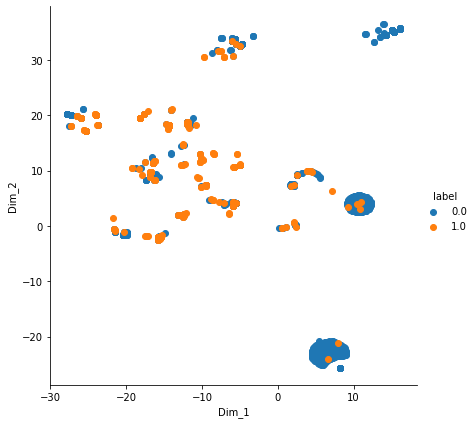

In [32]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

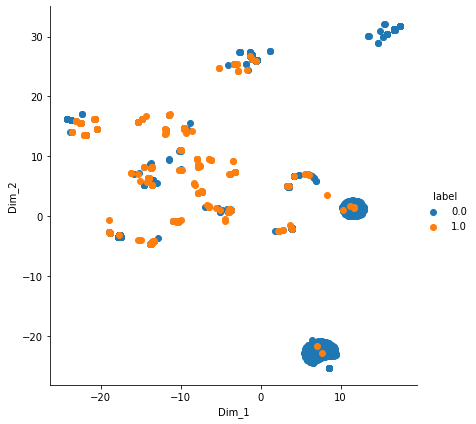

In [33]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [37]:
from sklearn.ensemble import RandomForestRegressor
df = dataFrame.copy(deep=True)
print(df.head())
model = RandomForestRegressor(random_state=1, max_depth=10)
dic = {"Ham": 0,"Phishing": 1}
df['Class']= df['Class'].replace(dic)
labels = df['Class']
df = df.drop('Class',axis = 1)
print(df.shape,labels.shape)
model.fit(df,labels)

          Class   HTML  HTMLForm  IFrame  FlashContent  General Salutation  \
Phishing  False  False     False   False          True               False   
Ham       False  False     False   False         False               False   
Ham       False  False     False   False         False               False   
Ham       False   True     False   False         False               False   
Phishing  False  False     False   False          True               False   

          Javascript  Number of URLs  Malicious URL  text link disparity  \
Phishing           2               1              0                    0   
Ham                2               0              0                    0   
Ham                1               0              0                    0   
Ham               78               1              0                    0   
Phishing           2               1              0                    0   

          Attachments  IP URLs  hexadecimal URL  Bad Rank Domain  \
Phishi

TypeError: Cannot compare types 'ndarray(dtype=bool)' and 'str'

In [ ]:
features = df.columns
print(features)
importances = model.feature_importances_
print(importances)
indices = np.argsort(importances)[-13:]  # top 10 features
print(indices)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [18]:
def headersFilters(mails, label):
    mail = mails[130]
    msg = email.message_from_string(mail)
    print(msg.get_charset())
    #         for part in msg.get_payload():
    #             print (part)
    #         print(msg.is_multipart())
    print("==============================\n\n")
    print(msg.keys())
    print(len(msg["Received"]))

    for part in msg.walk():
        print(part.get_content_type())


headersFilters(phishing, 1)
headersFilters(ham, 1)

None


['Return-Path', 'X-Original-To', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Subject', 'X-Originating-Server', 'X-Mailer', 'X-Priority', 'MIME-Version', 'Content-Type', 'Message-Id', 'Date', 'Status', 'X-Status', 'X-Keywords', 'X-UID']
174
multipart/related
text/html
image/gif
None


['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'X-Authentication-Warning', 'Received', 'Received', 'Received', 'Content-Class', 'MIME-Version', 'Content-Type', 'Subject', 'X-Mimeole', 'Date', 'Message-Id', 'X-MS-Has-Attach', 'X-MS-Tnef-Correlator', 'Thread-Topic', 'Thread-Index', 'From', 'To', 'Content-Transfer-Encoding', 'X-MIME-Autoconverted', 'Sender', 'Errors-To', 'X-Mailman-Version', 'Precedence', 'List-Id', 'X-Beenthere']
163
text/plain


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

NameError: name 'X' is not defined

In [20]:
# check dataset shapes
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

NameError: name 'X_train' is not defined